In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info_bell(labels, n_inp, n_layers, pars, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    s0n = array([1] + [0]*(2**n_inp - 1))
    s1n = array([0]*(2**n_inp - 1) + [1])
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    ansatz = hea_cry_rzrx(n_tot,n_layers, pars_ans)

    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    vs = []
    vs_der = []
    QFIs = []
    for N in labels:
        g = sqrt(max(0, 1 - N**2)) # cope negative sqrt
        v = (sqrt(1 + g)*s0n + sqrt(1 - g)*s1n)/sqrt(2)
        g_p = sqrt(1 + N)
        g_m = sqrt(1 - N)
        n1 = -N/(2*g_m*g_p*sqrt(1 + g_m*g_p))
        n2 =  N/(2*g_m*g_p*sqrt(1 - g_m*g_p))
        v_der = (n1*s0n + n2*s1n)/sqrt(2)

        v_der = sum([reduce(kron, [v]*c + [v_der] + [v]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient
        v = reduce(kron, [v]*n_copies)
        QFI = 4*(vdot(v_der, v_der) - vdot(v_der, v)*vdot(v, v_der)).real + 1e-10
        
        vs.append(v)
        vs_der.append(v_der)
        QFIs.append(QFI)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [(vs[j].conj().T@proj@vs[j]).real for proj in projs_u]
        probs_der = [2*(vs_der[j].conj().T@proj@vs[j]).real for proj in projs_u]
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [3]:
n_train = 5
n_inp = 2
s0n = array([1] + [0]*(2**n_inp - 1))
s1n = array([0]*(2**n_inp - 1) + [1])
svs = []
# for p in linspace(0, 1, n_train + 2)[1:-1]: 
for p in uniform(0, 1, n_train): 
    c = randint(0, 2) 
    v = (sqrt(1 + (-1)**c*sqrt(1 - p**2))*s0n + sqrt(1 - (-1)**c*sqrt(1 - p**2))*s1n)/sqrt(2)
    svs.append(v)
dms = [outer(sv, sv.conj().T) for sv in svs]
labels = [concurrence_pure(dm) for dm in dms]

dms_train = [dm for _, dm in sorted(zip(labels, dms))]
labels_train = np.sort(labels)

In [4]:
n_copies = 1
n_meas = 1#n_inp*n_copies
n_layers = 1
w_ls = 1e0
w_var = 1e-4
dp = 1e-5
x0 = concatenate([normal(pi, 0.025, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0, 1e-2, 2**n_meas)])

time_start = time()
fvals, result = train(dms_train, labels_train, n_layers, method="BFGS", n_copies=n_copies, n_meas=n_meas, w_ls=w_ls, w_var=w_var, x0=x0)
time_finish = time() - time_start
print("Finished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

Finished in 0.5292069911956787e: 0.00040733
Cost: 0.00040732525624005754
Optimization terminated successfully.


### Training set

In [5]:
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info_bell(labels_train, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)

n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 9.112742869418156e-06


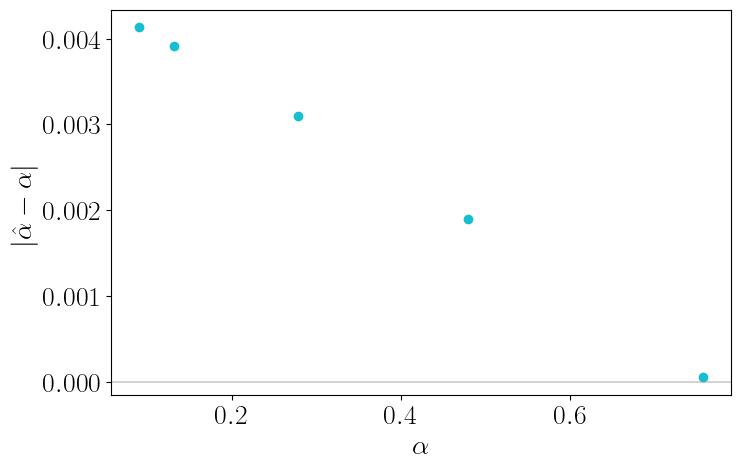

Sum var: 0.8092957806377269


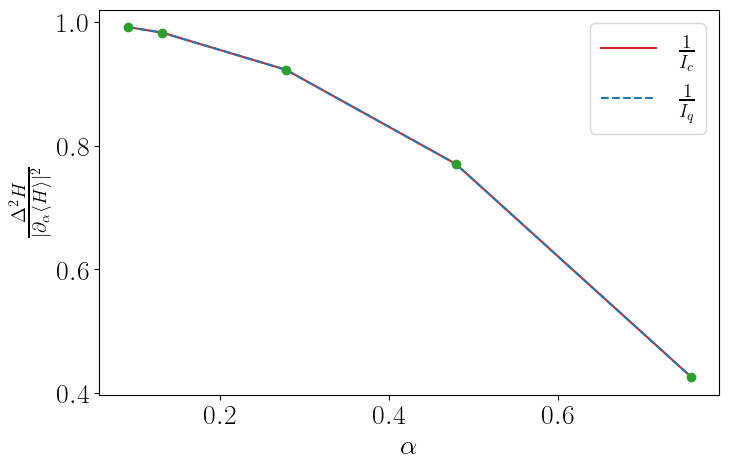

In [6]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("Sum error:", sum(np.abs(labels_train - expecs_train)**2)/n_train)
plt.figure(figsize=(8, 5))
plt.scatter(labels_train, np.abs(expecs_train - labels_train), marker="o", color="tab:cyan", zorder=3)
plt.axhline(0, color="black", linewidth=0.25)
# plt.plot(linspace(0, 1), linspace(0, 1), color="black", linewidth=0.25)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$|\hat{\alpha} - \alpha|$")
# plt.grid()
plt.show()

print("Sum var:", sum(disps_train)/n_train)
plt.figure(figsize=(8, 5))
plt.scatter(labels_train, disps_train/expecs_der_train**2, color="tab:green", zorder=3)
# plt.plot(np.sort(labels), [(1 - p**2) for p in np.sort(labels)], color="tab:blue", label=r"$\frac{1}{\mu I_q}$")
plt.plot(labels_train, 1/CFIs_train, color="tab:red", label=r"$\frac{1}{I_c}$")
plt.plot(labels_train, 1/QFIs_train, color="tab:blue", label=r"$\frac{1}{I_q}$", linestyle="dashed")
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
# plt.grid()
plt.legend()
# plt.yscale("log")
plt.show()

### Testing set

In [7]:
n_test = 10
    
svs_test = []
for p in concatenate([[1e-5], linspace(0, 1, n_test + 2)[1:-1], [1 - 1e-5]]):
    c = randint(0, 2)
    g = (-1)**c*sqrt(max(0, 1 - p**2))
    v = (sqrt(1 + g)*s0n + sqrt(1 - g)*s1n)/sqrt(2)
    svs_test.append(v)
    
dms_test = [outer(sv, sv.conj().T) for sv in svs_test]
labels_test = [concurrence_pure(dm) for dm in dms_test]

dms_test = [dm for _, dm in sorted(zip(labels_test, dms_test))]
labels_test = np.sort(labels_test)

expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info_bell(labels_test, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
biass_test = expecs_test - labels_test

In [23]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/"

n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 


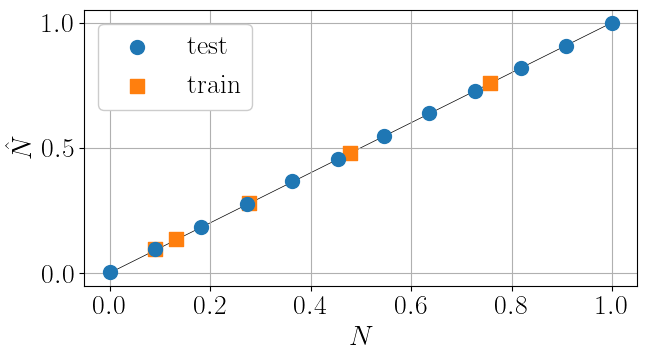

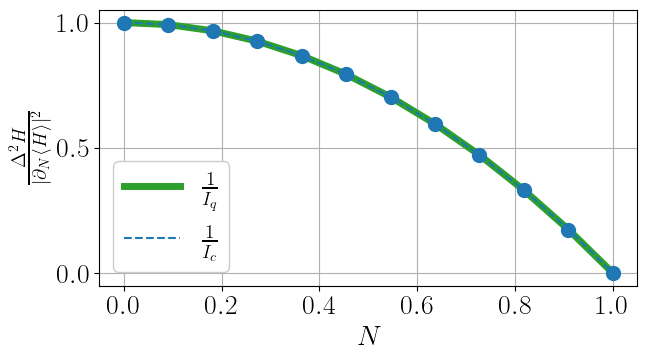

In [26]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
# plt.scatter(labels_test, np.abs(expecs_test - labels_test), s=30, linestyle="", label=r"$(\hat{C} - C)^2$", color="tab:cyan", zorder=3)
# plt.axhline(0, color="black", linewidth=0.25)
# plt.ylabel(r"$\hat{\alpha}$")
plt.scatter(labels_test, expecs_test, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.plot(linspace(0, 1), linspace(0, 1), color="black", linewidth=0.5, zorder=-1)
# plt.axhline(0, color="black", linewidth=0.25)
plt.ylabel(r"$\hat{N}$")
plt.xlabel(r"$N$")
# plt.grid()
plt.legend(framealpha=1)#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.tight_layout()
plt.grid()
# plt.savefig(save_path + "bell-est-test.pdf", bbox_inches='tight', transparent=True)
plt.show()

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test/expecs_der_test**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, disps_test, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.plot(linspace(0, 1), linspace(0, 1), color="black", linewidth=0) # lame
plt.xlabel(r"$N$")
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
# plt.grid()
# plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
plt.legend(ncol=1, loc=3, framealpha=1)#
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + "bell-var-test.pdf", bbox_inches='tight', transparent=True)
plt.show()

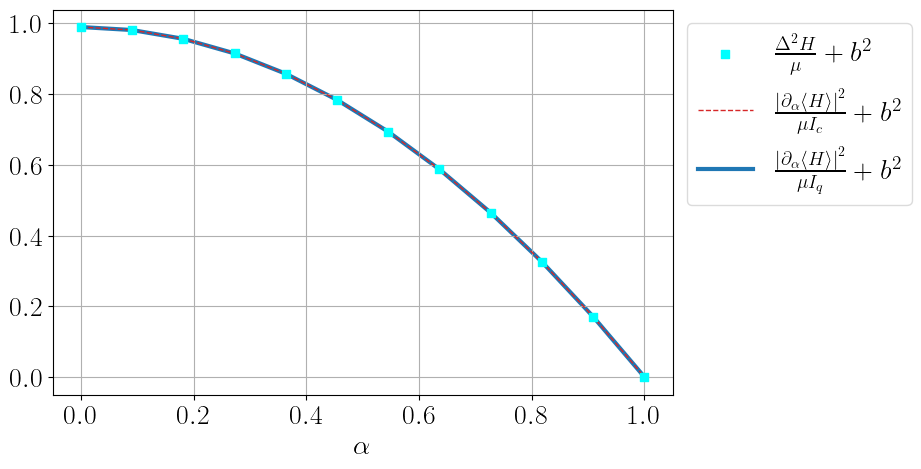

In [10]:
mu = 1e0

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, disps_test/mu + biass_test**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(labels_test, expecs_der_test**2/CFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(labels_test, expecs_der_test**2/QFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

### Finite size statistics simulation

In [16]:
n_shots = 1000
n_est = 1000
preds_test, errors_test = estimate(dms_test, labels_test, n_layers, pars,
                                   n_copies=n_copies, n_meas=n_meas, n_shots=n_shots, n_est=n_est)

n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.000762


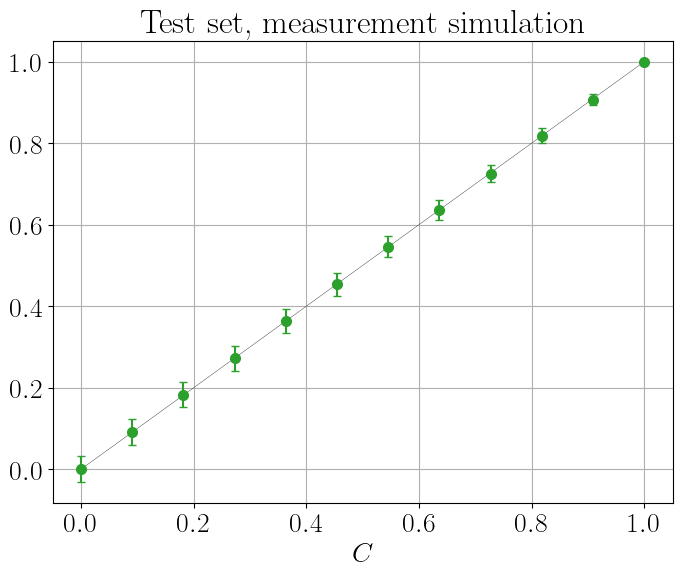

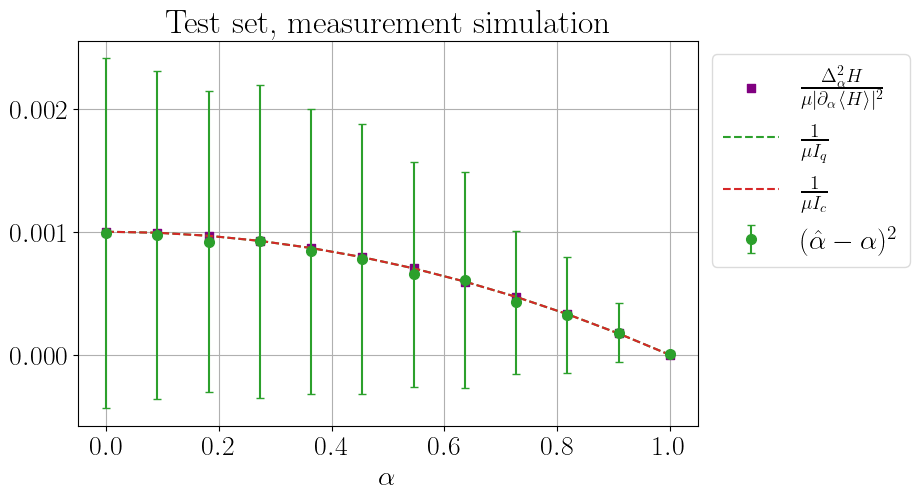

In [17]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("Sum error: %f" %(sum(mean(errors_test, axis=0))/n_test))
plt.figure(figsize=(8, 6))
plt.errorbar(labels_test, y=mean(preds_test, axis=0), markersize=7, yerr=std(preds_test, axis=0), marker="o", capsize=3, linestyle="", label=r"$(\hat{C} - C)^2$", color="tab:green", zorder=3)
plt.plot(linspace(0, 1), linspace(0, 1), color="black", linewidth=0.25)
plt.xlabel(r"$C$")
plt.xlabel(r"$C$")
plt.title("Test set, measurement simulation")
plt.grid()
# plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(8, 5))
# plt.scatter(labels_test, np.abs(mean(preds_test, axis=0) - array(labels_test)), marker="s", label=r"$|\hat{\alpha} - \alpha|$", color="tab:red", zorder=3)
plt.errorbar(labels_test, y=mean(errors_test, axis=0), markersize=7, yerr=std(errors_test, axis=0), marker="o", capsize=3, linestyle="", label=r"$(\hat{\alpha} - \alpha)^2$", color="tab:green", zorder=3)
# plt.scatter(labels_test, np.var(preds_test, axis=0), marker="x", s=100, color="cyan", label=r"$\Delta^2\,\hat{f}$")
plt.scatter(labels_test, disps_test/expecs_der_test**2/n_shots, marker="s", color="purple", label=r"$\frac{\Delta^2_\alpha H}{\mu|\partial_\alpha \langle H \rangle |^2}$")
plt.plot(labels_test, 1/QFIs_test/n_shots, color="C2", label=r"$\frac{1}{\mu I_q}$", linestyle="dashed")
plt.plot(labels_test, 1/CFIs_test/n_shots, color="C3", label=r"$\frac{1}{\mu I_c}$", linestyle="dashed")
plt.xlabel(r"$\alpha$")
plt.title("Test set, measurement simulation")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig(save_path + file_info + "-mse-test.pdf", bbox_inches='tight')
plt.show()